In [1]:
#readFeats
import numpy as np
import pandas as pd
import sklearn
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline
import os
from sklearn.utils import shuffle
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import hyperopt
from hyperopt import  hp, fmin, tpe, STATUS_OK, Trials
xgb.__file__

/home/xuhuang/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


'/home/xuhuang/anaconda2/lib/python2.7/site-packages/xgboost/__init__.pyc'

In [2]:
inj = pd.read_csv("../Data/Injected_feat_files_10000_fixed.csv", index_col=0)
inv = pd.read_csv("../Data/Inverted_feat_files_fixed.csv", index_col=0)
inj_periods = np.loadtxt("../../Training/simulation/injection/injection.txt", dtype= str, delimiter=",")[:10000, 3].astype("float64")


In [3]:
SNR_inj = np.loadtxt("../Data/SNR_10000_corrected.txt")[:10000]
correct_sig = np.loadtxt("../Data/period_harmonics_10000_inj_signals_tol_5x5.txt")
#print inj_periods
enough_transits = ((26./inj_periods) > 3).astype(int)
print enough_transits
one_harmonic = ((correct_sig[:,0]==1)+(correct_sig[: ,1]==1) + (correct_sig[:,0] == correct_sig[:,1])).astype(int)
print "Harmonic Cut", len(np.where(one_harmonic==1)[0])
print "SNR Cut", len(np.where(SNR_inj>6)[0])
true_trans = ((SNR_inj>=6)*(correct_sig[:,2]<0.002)*(one_harmonic==1)*(enough_transits)).astype(int)
print "Retained Transits", len(np.where(true_trans==1)[0])

inj["Y"] = true_trans
zero_length = np.zeros(inv.shape[0])
inv["Y"] = zero_length
total_signals = pd.concat([inj, inv], axis = 0)

drop_columns = [x for x in total_signals.columns.values.tolist() if "BLS"  in x]
total_signals= total_signals.drop(drop_columns, axis =1)
print total_signals.columns.values
labels = total_signals["Y"]
del  total_signals["Y"]
total_signals = total_signals.replace(np.nan, 0)
total_signals = total_signals.replace(np.inf, 0)
total_signals = total_signals.replace(-np.inf, 0)
print total_signals.columns.values
object_label = np.ones_like(true_trans)#vi
object_label[true_trans==1] =2 
inv_labels = np.zeros(inv.shape[0])
inv_labels.fill(3)
object_label = np.append(object_label, inv_labels)
print np.unique(object_label)

[1 0 0 ..., 1 1 0]
Harmonic Cut 9565
SNR Cut 9255
Retained Transits 6215
['mod_sig_pri_dv' 'mod_sig_sec_dv' 'mod_sig_ter_dv' 'mod_sig_pos_dv'
 'mod_fa1_dv' 'mod_fa2_dv' 'mod_fred_dv' 'modshiftval1_dv'
 'modshiftval2_dv' 'modshiftval3_dv' 'modshiftval4_dv' 'modshiftval5_dv'
 'modshiftval6_dv' 'white_noise' 'red_noise' 'Y']
['mod_sig_pri_dv' 'mod_sig_sec_dv' 'mod_sig_ter_dv' 'mod_sig_pos_dv'
 'mod_fa1_dv' 'mod_fa2_dv' 'mod_fred_dv' 'modshiftval1_dv'
 'modshiftval2_dv' 'modshiftval3_dv' 'modshiftval4_dv' 'modshiftval5_dv'
 'modshiftval6_dv' 'white_noise' 'red_noise']
[ 1.  2.  3.]


In [4]:
correct_sig[273,:2].astype(int)

array([3, 3])

In [5]:
shuffleX, shuffleY , shuffle_labels= shuffle(total_signals, labels, object_label, random_state =0)
shuffleX = shuffleX.reset_index(drop = True)
shuffleY = shuffleY.reset_index(drop = True)

print shuffleX.shape, shuffleY.shape #, train_label.shape

trainX, testX, trainY, testY, train_label, test_label = train_test_split(shuffleX, shuffleY, shuffle_labels, stratify =shuffle_labels, test_size = 0.20,random_state = 0 )

print "Strong Transits in training" , len(np.where([(trainY==1) & (train_label==2)])[0]) 
print "Weak Transits in training" , len(np.where([(trainY==0) & (train_label==1)])[0]) 
print "Inverted Signals in training" , len(np.where([(trainY==0) & (train_label==3)])[0]) , "\n"
print "Strong Transits in testing" , len(np.where([(testY==1) & (test_label==2)])[0]) 
print "Weak Signals in testing" , len(np.where([(testY==0) & (test_label==1)])[0]) 
print "Inverted Signals in testing" , len(np.where([(testY==0) & (test_label==3)])[0]) 

#print "\n",shuffleX.columns.values

(25000, 15) (25000,)
Strong Transits in training 4972
Weak Transits in training 3028
Inverted Signals in training 12000 

Strong Transits in testing 1243
Weak Signals in testing 757
Inverted Signals in testing 3000


In [6]:
# try tuning, which is fairly important here with all the noise and tolerance cuts
space ={
        'max_depth': hp.quniform('x_max_depth', 1, 20,1),
        'min_child_weight': hp.quniform ('x_min_child', 1, 20, 1),
        'subsample': hp.uniform ('x_subsample', 0.7, 1),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.7,1),
        'learning_rate': hp.uniform ('x_learning_rate', 0.001, 0.1)
}

#implemented with xgb cv

dtrain = xgb.DMatrix(trainX, label=trainY)

def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'])
    start = time.time()
    
    cv_result = xgb.cv(clf.get_xgb_params(),dtrain, num_boost_round=50, nfold=5, metrics='auc', early_stopping_rounds=5 )
    end = time.time()
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    score =  cv_result.iloc[-1]["test-auc-mean"]
    score_std =  cv_result.iloc[-1]["test-auc-std"]
    print ("SCORE %f, in : %f s:" % (score, (end-start)))

    return{'loss':1-score, 'status': STATUS_OK, "cv_score":score, "test_avg": score_std }




In [7]:
trials= Trials()
import time
start = time.time()
#best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 5, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))
#print best

('Optimization Time: %f seconds', 3.409385681152344e-05)


In [47]:
# try cross validation
#xgbc = XGBClassifier(n_estimators = 500, seed=8, max_depth = int(best["x_max_depth"]),
#                     colsample_bytree=best["x_tree_colsample"], 
#                     subsample=best["x_subsample"], scale_pos_weight=2,
#                    min_child_weight = best["x_min_child"], learning_rate = best["x_learning_rate"])
xgbc = XGBClassifier(seed = 0, n_estimators=500, max_depth=15, min_child_weight=5, subsample=0.9, scale_pos_weight=3, colsample_bytree=0.8)
xgb_params  = xgbc.get_params()
dtrain = xgb.DMatrix(shuffleX, label=shuffleY)
scores = xgb.cv(xgb_params, dtrain, metrics="auc", seed=0 ,nfold=5, stratified=True)
np.mean(scores)

test-auc-mean     0.995684
test-auc-std      0.000725
train-auc-mean    0.998173
train-auc-std     0.000090
dtype: float64

0.960739620556
0.956694477553


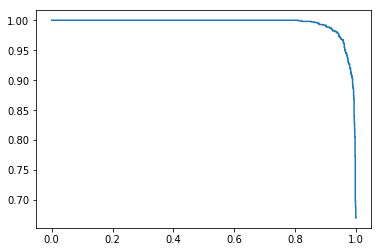

In [48]:
xgbc.fit(trainX, trainY)
preds = xgbc.predict(testX)
preds_proba = xgbc.predict_proba(testX)[:,1]
print metrics.average_precision_score(testY, preds)
print metrics.f1_score(testY, preds)
preds = xgbc.predict(testX)
precision, recall, threholds = metrics.precision_recall_curve(testY, preds_proba)
plt.plot(recall, precision)

In [49]:
#try determine  things like false positive rate
print "Precision", metrics.precision_score(testY, preds)
print "Recall", metrics.recall_score(testY, preds)
print "ROC" , metrics.roc_auc_score(testY, preds)
#print len(preds)

false_positive_inverted  = len(np.where([(preds==1) & (testY==0) & (test_label==3)])[0])
false_positive_weak_sig  = len(np.where([(preds==1) & (testY==0) & (test_label==1)])[0])
false_negative_strong_sig  = len(np.where([(preds==0) & (testY==1) & (test_label==2)])[0])

#how many weak, and strong signals and inverted in test sample?
print "Inverted", len(np.where([(testY==0) & (test_label==3)])[0])
print "Strong Transit", len(np.where([(testY==1) & (test_label==2)])[0])
print "Weak transit ", len(np.where([(testY==0) & (test_label==1)])[0]) ,"\n"

print "Num of false positive inverted,  and false_negative strong sig, false positive weak sig"
print false_positive_inverted,  false_negative_strong_sig, false_positive_weak_sig


#how many weak, and strong signals and inverted in test sample?
print "Inverted Percent False Positive Rate", float(false_positive_inverted) / len(np.where([(testY==0) & (test_label==3)])[0])
print "Strong Transit False Negative Rate?", float(false_negative_strong_sig) / len(np.where([(testY==1) & (test_label==2)])[0])
print "Weak transit False Positive Rate", float(false_positive_weak_sig) / len(np.where([(testY==0) & (test_label==1)])[0])

Precision 0.945054945055
Recall 0.968624296058
ROC 0.974996204457
Inverted 3000
Strong Transit 1243
Weak transit  757 

Num of false positive inverted,  and false_negative strong sig, false positive weak sig
0 39 70
Inverted Percent False Positive Rate 0.0
Strong Transit False Negative Rate? 0.0313757039421
Weak transit False Positive Rate 0.0924702774108


(4251, 3)
Retained Transits 681 from 4251
(4251, 35)
['mod_sig_pri_dv' 'mod_sig_sec_dv' 'mod_sig_ter_dv' 'mod_sig_pos_dv'
 'mod_fa1_dv' 'mod_fa2_dv' 'mod_fred_dv' 'modshiftval1_dv'
 'modshiftval2_dv' 'modshiftval3_dv' 'modshiftval4_dv' 'modshiftval5_dv'
 'modshiftval6_dv' 'white_noise' 'red_noise']
(4251, 3)


(array([  1.90100000e+03,   9.84000000e+02,   5.29000000e+02,
          3.10000000e+02,   1.09000000e+02,   8.20000000e+01,
          4.70000000e+01,   1.90000000e+01,   2.80000000e+01,
          3.40000000e+01,   2.40000000e+01,   2.70000000e+01,
          2.40000000e+01,   1.70000000e+01,   3.00000000e+00,
          3.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([   0.        ,    5.26315789,   10.52631579,   15.78947368,
          21.05263158,   26.31578947,   31.57894737,   36.84210526,
          42.10526316,   47.36842105,   52.63157895,   57.89473684,
          63.15789474,   68.42105263,   73.68421053,   78.94736842,
          84.21052632,   89.47368421,   94.73684211,  100.        ]),
 <a list of 19 Patch objects>)

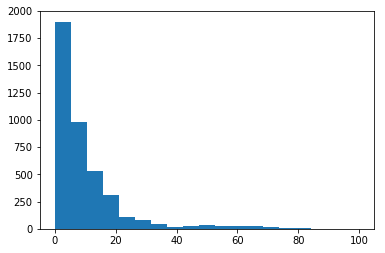

In [101]:
#load the testing _kois
koi_SNR = np.loadtxt("../Data/SNR_feats_KOIS_4251_fixed.txt")
koi_SNR = np.nan_to_num(koi_SNR)
print koi_SNR.shape
koi_tol = np.loadtxt("../Data/period_harmonics_4251_koi_signals_tol_5x5_ordered.txt")
koi = pd.read_csv("../Data/KOI_feat_files_4251_fixed_ordered.csv", index_col=0)

koi_periods = np.loadtxt("../Data/koi_periods_ordered.txt")
#print koi_periods
enough_trans = (26//koi_periods > 3).astype(int)

koi_true = ((koi_SNR[:, -1]>6)* (koi_tol[:,2]<0.002) * (enough_trans)).astype(int)
#koi_tol = np.loadtxt("//")
print "Retained Transits", len(np.where(koi_true==1)[0]), "from", koi.shape[0]
print koi.shape
koi = koi.drop(drop_columns, axis=1)
print koi.columns.values
print koi_SNR.shape
plt.hist(koi_SNR[:, 2], bins = np.linspace(0, 100, 20))

In [51]:
print koi_SNR[:,2].min()
preds = xgbc.predict(testX)

0.0


In [102]:
preds =  xgbc.predict(koi)
print "\nScores with the SNR and tol cut made to the true values"


print  "True kois", len(np.where(koi_true==1)[0])
print preds.shape
#strong false objects classifed s true
print "Strong false KOI classified as true", len(np.where((koi_true==0) * (koi_tol[:,2]>0.002) * (preds==1))[0]) ,"from", len(np.where((koi_SNR[:,2]>6)*(koi_tol[:,2]>0.002))[0])
print "Strong true KOI classified as false", len(np.where((koi_true==1) * (preds==0))[0]) ,"from", len(np.where((koi_SNR[:,2]>6)*(koi_tol[:,2]<0.002))[0])

print "Weak true KOI classified as true", len(np.where((koi_SNR[:,2]<6) * (koi_tol[:,2]<0.002) * (preds==1))[0]) ,"from", len(np.where((koi_SNR[:,2]<6)*(koi_tol[:,2]<0.002))[0])

print "Weak false KOI classified as true", len(np.where((koi_SNR[:,2]<6) * (koi_tol[:,2]>0.002) * (preds==1))[0]) ,"from", len(np.where((koi_SNR[:,2]<6)*(koi_tol[:,2]>0.002))[0])






Scores with the SNR and tol cut made to the true values
True kois 681
(4251,)
Strong false KOI classified as true 131 from 876
Strong true KOI classified as false 402 from 1287
Weak true KOI classified as true 15 from 92
Weak false KOI classified as true 92 from 1996


In [118]:
star_list_ids = np.unique(koi_SNR[:,0])

partially_detected = np.zeros_like(star_list_ids)
detection_counts = np.zeros_like(star_list_ids)
normalized_detection_counts = np.zeros_like(star_list_ids)
not_detected = np.zeros_like(star_list_ids)
should_be_detected = np.zeros_like(star_list_ids)

star_SNR =np.zeros_like(star_list_ids)
star_tol = np.zeros_like(star_list_ids)
star_transits = np.zeros_like(star_list_ids)

print "Unique starts" ,len(star_list_ids)
#print koi_SNR
for i,id_num in enumerate(star_list_ids):
    indices = np.where(id_num == koi_SNR[:,0])[0]
    #print indices
    if  preds[indices].sum() >=1:
        partially_detected[i] = star_list_ids[i]
    else  :
        not_detected[i] = star_list_ids[i]
    detection_counts[i]=preds[indices].sum()
    normalized_detection_counts[i] = np.nansum(preds[indices]/float(len(preds[indices])))
    should_be_detected[i] = np.mean(koi_true[indices])
    
    #other params
    star_SNR[i] = np.median(koi_SNR[indices,2])
    star_transits[i] = np.median(26//koi_periods[indices])
    star_tol[i] = np.median(koi_tol[indices,2])

print "Stars detected", len(np.where(partially_detected!=0)[0])
print "Stars that should be detected", len(np.where(should_be_detected!=0)[0])

#plt.hist(detection_counts)
#plt.hist(normalized_detection_counts)


print "Stars Missed" , len(not_detected[np.where(not_detected!=0)[0]])
print "Stars detected", len(np.where(partially_detected!=0)[0])


#iterate over msised stars
old_star_ids = [ 5735762. ,  6198182.,   6278762. , 10545066.,  10748390. , 11100383., 11709006.]

#print star_list_ids[np.where( (star_tol>0.002) &(star_SNR>6))[0]]
#'''
for i, id_num in enumerate(star_list_ids[np.where( (star_tol>0.002) &(star_SNR>6))[0]][:10]):
    #if id_num in old_star_ids:
        indices = np.where(id_num == koi_SNR[:,0])[0]
        print "ID:", id_num
        print "KOI_SNR:", koi_SNR[indices,2]
        print "KOI_SNR_MEAN:", np.median(koi_SNR[indices,2])
        print "YLabels", koi_true[indices]
        print "KOI tol err ", koi_tol[indices,2]
        print "KOI tol err mean", np.median(koi_tol[indices,2])
        print "Periods", koi_periods[indices][0], "\n"
        print i,"-------------------------------------\n"
        #break
''''''
print "Weak stars detected with low period err:", len(np.where( (partially_detected>0)& (star_tol<0.002) &(star_SNR<6))[0]), \
     "from", len(np.where( (star_tol<0.002) &(star_SNR<6))[0])
print "Weak stars detected with high period err:", len(np.where( (partially_detected>0)& (star_tol>0.002) & (star_SNR<6))[0]) ,\
 "from", len(np.where( (star_tol>0.002) &(star_SNR<6))[0])
print "Strong stars detected with low period err:", len(np.where( (partially_detected>0)& (star_tol<0.002) &(star_SNR>6))[0]), \
 "from", len(np.where( (star_tol<0.002) &(star_SNR>6))[0])

print "Strong stars detected with high period err:", len(np.where( (partially_detected>0)& (star_tol>0.002) &(star_SNR>6))[0]), \
 "from", len(np.where( (star_tol>0.002) &(star_SNR>6))[0])
print "Strong stars with low period err but not enough transits", len(np.where((star_transits<3)* (star_SNR>6) * (star_tol<0.002))[0])
print star_list_ids[np.where( (star_tol>0.002) &(star_SNR>6))[0]]

Unique starts 284
Stars detected 109
Stars that should be detected 65
Stars Missed 175
Stars detected 109
ID: 2304320.0
KOI_SNR: [ 7.00250733  6.0013242   6.81057033  6.9897986   6.81358519  5.52169037
  5.6101661   6.84689605  5.7397601   5.68049966  6.17208178  5.60200586
  5.4941213   6.25223663  5.90702305  6.08432516]
KOI_SNR_MEAN: 6.04282468251
YLabels [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
KOI tol err  [  1.45703721e+00   1.55471521e+00   1.19090654e-03   1.29690190e+00
   4.06848162e-02   9.82675967e-02   1.37834009e+00   1.19388877e+00
   1.00787170e+00   2.93166102e-01   5.34556041e-02   7.01597111e-01
   2.45406153e-02   1.07829843e+00   7.74699005e-01   1.53397848e+00]
KOI tol err mean 0.89128535506
Periods 16.54081386 

0 -------------------------------------

ID: 2438513.0
KOI_SNR: [ 9.01201257  7.7636132   8.20384399  8.5986597   9.3539721   6.32940683
  6.9580463   8.98767223  9.22755117  6.71072952  6.91467146  7.00565398
  8.26240009  8.77438534  5.41747215  5.58805313  5.

In [125]:
print len(np.unique(koi_SNR[np.where((koi_periods>8.67) * (koi_periods<13))[0],0]))
old_star_ids = [ 5735762. ,  6198182.,   6278762. , 10545066.,  10748390. , 11100383., 11709006.]
#print old_star_ids in not_detected[np.where(not_detected!=0)[0]]
#print not_detected[np.where(not_detected!=0)[0]]
for old_star in old_star_ids:
    print old_star in not_detected[np.where(not_detected!=0)[0]]
    print old_star, "\n"
8.67*3


43
True
5735762.0 

True
6198182.0 

True
6278762.0 

True
10545066.0 

True
10748390.0 

True
11100383.0 

True
11709006.0 



26.009999999999998

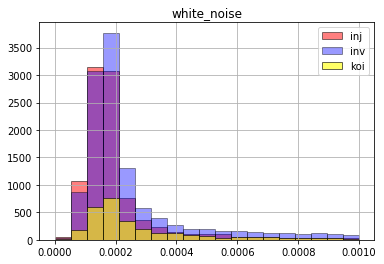

In [15]:
# Examine noise distributions
def plot_property(name, bins = np.linspace(0,1e-3, 20 )):
    fig = plt.figure()
    ax = fig.add_subplot("111")
    #print inj.columns.values
    #bins = np.linspace(0,1e-3, 20 )
    inj.hist(name, alpha = 0.5, bins = bins , edgecolor = "black", linewidth = 1, ax  = ax, label = "inj", color = "red")
    inv.hist(name, alpha = 0.4, bins = bins , edgecolor = "black", linewidth = 1, ax = ax, label = "inv", color = "blue")
    koi.hist(name, alpha = 0.6, bins = bins , edgecolor = "black", linewidth = 1, ax = ax,label = "koi", color = "yellow")
    plt.legend()
plot_property("white_noise")

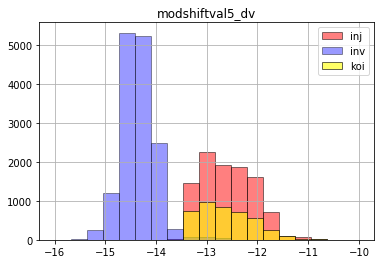

In [16]:
plot_property("modshiftval5_dv", bins = np.linspace(-16, -10, 20))

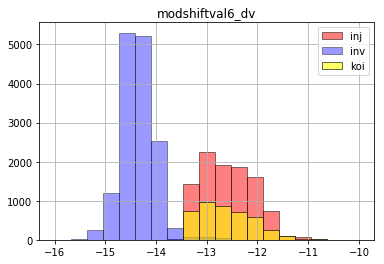

In [17]:
plot_property("modshiftval6_dv", bins = np.linspace(-16, -10, 20))

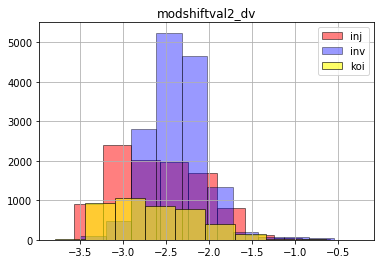

In [18]:
plot_property("modshiftval2_dv", bins = None)

In [19]:
#where is secondary signifcance relateive to tertiarty event equal to secondary significance compared to positive event
print len(np.where(koi["modshiftval5_dv"] == koi['modshiftval6_dv'])[0])
print len(np.where(inj["modshiftval5_dv"] == inj['modshiftval6_dv'])[0])
print len(np.where(inv["modshiftval5_dv"] == inv['modshiftval6_dv'])[0])


0
0
0


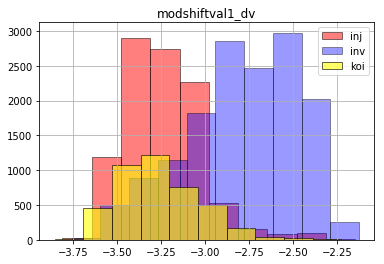

In [20]:
plot_property("modshiftval1_dv", bins = None)
#odd, as this shows that most are not significant

In [21]:
star_list_ids

array([  1161345.,   1718958.,   1865042.,   2299738.,   2302548.,
         2304320.,   2438513.,   2441495.,   2444412.,   2571238.,
         2692377.,   2831055.,   2849805.,   2853446.,   2970670.,
         2985767.,   2989404.,   3102384.,   3129238.,   3328080.,
         3440118.,   3446746.,   3541946.,   3544595.,   3545135.,
         3733628.,   3852655.,   3934657.,   4048898.,   4049901.,
         4149450.,   4164922.,   4180280.,   4278221.,   4349442.,
         4365645.,   4472818.,   4563268.,   4644604.,   4644952.,
         4813793.,   4827723.,   4840672.,   4857213.,   4947556.,
         4991208.,   5020319.,   5084942.,   5088536.,   5185897.,
         5253802.,   5272233.,   5339567.,   5369827.,   5375194.,
         5383248.,   5612697.,   5613821.,   5652893.,   5683219.,
         5688683.,   5695396.,   5709906.,   5735762.,   5794570.,
         5796675.,   5809890.,   5859725.,   5881120.,   5941160.,
         5946568.,   5959719.,   6020753.,   6021275.,   60292

In [22]:
uni_Stars = len(np.unique(star_list_ids))
largest_seg = np.max(koi_SNR[:,1].max())
table = np.full((uni_Stars, largest_seg +2), np.nan, dtype="float64")
print table.shape

(284, 22)


/home/xuhuang/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:297: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


In [23]:
table[:,0] = star_list_ids
#print table
for i, info in enumerate(koi_SNR):
    #print info
    try:
        row_ind = np.where(info[0]==table[:, 0])[0]
        col_ind = info[1] +1 
        pred = preds[i]
        table[row_ind, col_ind]= pred
    #break
    except   Exception as e:
        print info, e
        #break
    #print row_ind, col_ind
    
print table

[[  1161345.         0.         0. ...,        nan        nan        nan]
 [  1718958.         0.         0. ...,        nan        nan        nan]
 [  1865042.         0.         0. ...,        nan        nan        nan]
 ..., 
 [ 12505503.         0.         0. ...,        nan        nan        nan]
 [ 12554212.         0.         0. ...,        nan        nan        nan]
 [ 12785320.         0.         0. ...,        nan        nan        nan]]


/home/xuhuang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [24]:
nums = np.arange(largest_seg+1)
print nums
col_names = ["Star_id"] + ["Seg"+(str(x)) for x in nums ]
print len(col_names), col_names
#
table_Vals = pd.DataFrame(table, columns=col_names)
table_Vals.head()
table_Vals.to_csv("../Data/predicted_koi_table.csv")

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.]
22 ['Star_id', 'Seg0.0', 'Seg1.0', 'Seg2.0', 'Seg3.0', 'Seg4.0', 'Seg5.0', 'Seg6.0', 'Seg7.0', 'Seg8.0', 'Seg9.0', 'Seg10.0', 'Seg11.0', 'Seg12.0', 'Seg13.0', 'Seg14.0', 'Seg15.0', 'Seg16.0', 'Seg17.0', 'Seg18.0', 'Seg19.0', 'Seg20.0']


In [25]:
#print table
#print info.shape
table = np.full(table.shape, np.nan, "float64")
# 242 10971674.0
table[:, 0] = star_list_ids

for i, info in enumerate(koi_SNR):
    #print info
    try:
        row_ind = np.where(info[0]==table[:, 0])[0]
        col_ind = info[1] +1 
     
        table[row_ind, col_ind]= koi_true[i]
        if info[0] == 11600889:
            print koi_tol[i, 2], koi_SNR[i, 2], koi_periods[i], koi_true[i], enough_trans[i]
    #break
    except   Exception as e:
        print info, e
        #break
    #print row_ind, col_ind
    
#print table.astype("int64")
nums = np.arange(largest_seg+1)
#print nums
col_names = ["Star_id"] + ["Seg"+(str(x)) for x in nums ]
#print len(col_names), col_names
#
table_Vals = pd.DataFrame(table, columns=col_names)
table_Vals.head()
table_Vals.to_csv("../Data/true_koi_table.csv")


0.000441578177744 11.340199782 0.669310092 1 1
9.13406334954e-05 12.211871172 0.669310092 1 1
0.000208070238087 11.4290589172 0.669310092 1 1
0.000169156904556 12.0287305724 0.669310092 1 1
0.000169156904556 12.4390687748 0.669310092 1 1
0.000272927407696 12.4874660394 0.669310092 1 1
0.000310624757612 12.5952894188 0.669310092 1 1
0.000169156904556 10.9831613413 0.669310092 1 1
0.00018213814269 12.249159328 0.669310092 1 1
0.000363738300282 12.7656314396 0.669310092 1 1
0.00051802861901 12.5263672817 0.669310092 1 1
0.000843838469746 12.2678889293 0.669310092 1 1
0.000829050582173 11.8336273743 0.669310092 1 1
0.000103174243179 11.494554957 0.669310092 1 1
0.000298872084884 10.3125934486 0.669310092 1 1
0.00023401659822 10.0164786015 0.669310092 1 1


/home/xuhuang/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [26]:
table_Vals.head()

,Star_id,Seg0.0,Seg1.0,Seg2.0,Seg3.0,Seg4.0,Seg5.0,Seg6.0,Seg7.0,Seg8.0,...,Seg11.0,Seg12.0,Seg13.0,Seg14.0,Seg15.0,Seg16.0,Seg17.0,Seg18.0,Seg19.0,Seg20.0
0,1161345.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1718958.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1865042.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,2299738.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2302548.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
star_list_ids[:10]

array([ 1161345.,  1718958.,  1865042.,  2299738.,  2302548.,  2304320.,
        2438513.,  2441495.,  2444412.,  2571238.])

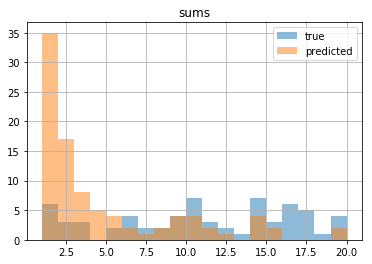

In [28]:
true_Vals = pd.read_csv("../Data/true_koi_table.csv")
pred_Vals = pd.read_csv("../Data/predicted_koi_table.csv")
def sum_partial(row):
    return np.nansum(row[2:])
true_Vals['sums'] = true_Vals.apply(sum_partial, axis=1)
bins = np.linspace(1,20,20)
pred_Vals["sums"] = pred_Vals.apply(sum_partial, axis =1)
#sums_pred = true_Vals.sum(axis= 1)
fig = plt.figure()
ax = fig.add_subplot("111")
true_Vals.hist('sums', ax = ax, alpha = 0.5, bins = bins, label = "true")
pred_Vals.hist("sums", ax = ax, alpha = 0.5, bins = bins, label = "predicted")
#print true_Vals['sums']
plt.legend()

In [29]:
print np.where(true_Vals["sums"]==1)[0]
print pred_Vals["Star_id"][np.where(true_Vals["sums"]==1)[0]]

[127 131 155 176 201 271]
127     7887791.0
131     7976520.0
155     8557374.0
176     9139084.0
201     9790806.0
271    11923284.0
Name: Star_id, dtype: float64


In [117]:
print koi_SNR[np.where(true_Vals["Star_id"]==2438513)[0]]
print koi_SNR[koi_SNR[:,0]==2438513]
#true_Vals.iloc[198,:]
#true_Vals.iloc[263,:]
#true_Vals.iloc[268,:]

[[  1.00009410e+07   6.00000000e+00   2.15832333e+00]]
[[  2.43851300e+06   0.00000000e+00   9.01201257e+00]
 [  2.43851300e+06   1.00000000e+00   7.76361320e+00]
 [  2.43851300e+06   2.00000000e+00   8.20384399e+00]
 [  2.43851300e+06   3.00000000e+00   8.59865970e+00]
 [  2.43851300e+06   4.00000000e+00   9.35397210e+00]
 [  2.43851300e+06   5.00000000e+00   6.32940683e+00]
 [  2.43851300e+06   6.00000000e+00   6.95804630e+00]
 [  2.43851300e+06   7.00000000e+00   8.98767223e+00]
 [  2.43851300e+06   8.00000000e+00   9.22755117e+00]
 [  2.43851300e+06   9.00000000e+00   6.71072952e+00]
 [  2.43851300e+06   1.00000000e+01   6.91467146e+00]
 [  2.43851300e+06   1.10000000e+01   7.00565398e+00]
 [  2.43851300e+06   1.20000000e+01   8.26240009e+00]
 [  2.43851300e+06   1.30000000e+01   8.77438534e+00]
 [  2.43851300e+06   1.40000000e+01   5.41747215e+00]
 [  2.43851300e+06   1.50000000e+01   5.58805313e+00]
 [  2.43851300e+06   1.60000000e+01   5.56585405e+00]
 [  2.43851300e+06   1.7000